In [1]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

import pickle
import ast

# Classify Subject Categories

In [2]:
lynda = pd.read_csv('data/jobs/lynda/lynda_2018-05-30.csv')
lynda['skills'] = lynda['skills'].apply(ast.literal_eval)
lynda['subjects'] = lynda['subjects'].apply(ast.literal_eval)
lynda['subject'] = lynda['subjects'].apply(lambda x: x[0])
lynda['skill'] = lynda['skills'].apply(lambda x: x[0])
lynda['title_desc'] = lynda['title'] + ' ' + lynda['description']

In [3]:
edx = pd.read_csv('data/jobs/edx/old_edx.csv', encoding='latin-1')
edx = edx[edx.subject != 'Missing']
edx.loc[(edx.description == 'Missing') | (edx.description.isnull()), 'description'] = \
                    edx.loc[(edx.description == 'Missing') | (edx.description.isnull()), 'title']
edx['description'] = edx['description'].str.replace('Learn', '')
edx['description'] = edx['description'].str.replace('learn', '')
edx['description'] = edx['description'].str.replace('how to', '')
edx['title_desc'] = edx['title'] + '' + edx['description']

In [4]:
coursera = pd.read_csv('data/jobs/coursera/coursera_2.csv')
coursera = coursera[coursera.subjects.notnull()]
coursera['subjects'] = coursera['subjects'].str.replace("'Home', ", '')
coursera['subjects'] = coursera['subjects'].apply(ast.literal_eval)
coursera['subject'] = coursera['subjects'].apply(lambda x: x[0])
coursera['title_desc'] = coursera['title'] + '' + coursera['description']
coursera = coursera[~coursera.title_desc.str.contains('curso')]

In [5]:
df = pd.concat([lynda[['title_desc', 'subject']].copy(), 
                edx[['title_desc', 'subject', ]].copy(),
                coursera[['title_desc', 'subject']].copy()])
df = df.apply(lambda x: x.str.lower())
df = df.drop_duplicates(subset='title_desc')
#df = df.apply(lambda x: x.str.slice(0, 200))


df['title_desc'] = df['title_desc'].str.replace('course', '')
df['title_desc'] = df['title_desc'].str.replace('learn', '')
df['title_desc'] = df['title_desc'].str.replace('include', '')
df['title_desc'] = df['title_desc'].str.replace('create', '')
df['title_desc'] = df['title_desc'].str.replace('capstone', '')
df['title_desc'] = df['title_desc'].str.replace('lesson', '')
df['title_desc'] = df['title_desc'].str.replace('create', '')
df['title_desc'] = df['title_desc'].str.replace('week', '')
df['title_desc'] = df['title_desc'].str.replace('video', '')
df['title_desc'] = df['title_desc'].str.replace('audio', '')

df.loc[df['subject'].str.contains('ethics|history|arts|culture|literature|law|social science'), 'subject'] = 'social science + humanities'
df.loc[df['subject'].str.contains('computer'), 'subject'] = 'developer'
df.loc[df['subject'].str.contains('music'), 'subject'] = 'music + audio'
df.loc[df['subject'].str.contains('earth|environment|chemistry|medicine|biology|life'), 'subject'] = 'science + medicine'
df.loc[df['subject'] == 'science', 'subject'] = 'science + medicine'
df.loc[df['subject'].str.contains('education'), 'subject'] = 'education'
df.loc[df['subject'].str.contains('business'), 'subject'] = 'business'
df.loc[df['subject'].str.contains('architecture'), 'subject'] = 'design'
df.loc[df['subject'].str.contains('food|health'), 'subject'] = 'health'
df.loc[df['subject'].str.contains('math|physics|electronics|engineer'), 'subject'] = 'math, physics + engineering'
df.loc[df['subject'].str.contains('language'), 'subject'] = 'language'
df.loc[df['subject'].str.contains('data'), 'subject'] = 'data science'
df.loc[df['subject'] == 'it', 'subject'] = 'information technology'

df.loc[df['title_desc'].str.contains('data science|machine learning|artificial intelligece|deep learning|hadoop'), 'subject'] = 'data science'

In [6]:
df['category_id'] = df['subject'].factorize()[0]

category_id_df = df[['subject', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'subject']].values)

In [7]:
df[['title_desc']].to_csv('data/jobs/topic_modeling/all_course_descriptions.csv', index=False, encoding='utf-8')

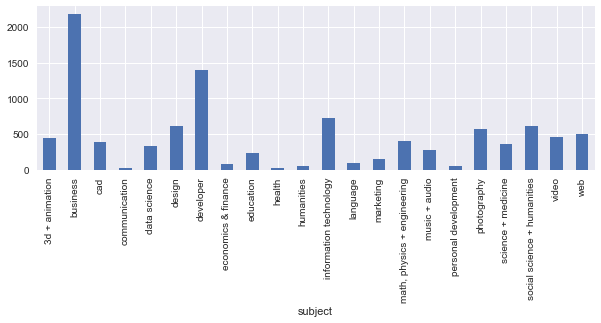

In [8]:
df.groupby('subject').title_desc.count().plot(kind='bar', figsize=(10,3));

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.title_desc).toarray()
labels = df.category_id
features.shape

(9950, 24460)

In [10]:
from sklearn.feature_selection import chi2
import numpy as np

N = 3
for subject, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    #print("# '{}':".format(subject))
    #print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    #print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['title_desc'], df['subject'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [11]:
NB = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = X_test.apply(lambda x: NB.predict(count_vect.transform([x])))

In [133]:
#pickle.dump(NB, open('data/jobs/classifiers/naive_bayes_lynda+edx+coursera.sav', 'wb'))
#NB = pickle.load(open('data/jobs/classifiers/naive_bayes_lynda+edx+coursera.sav', 'rb'))
#print(NB.predict(count_vect.transform(["machine learning is the science of machine learning has given us self-driving cars"])))

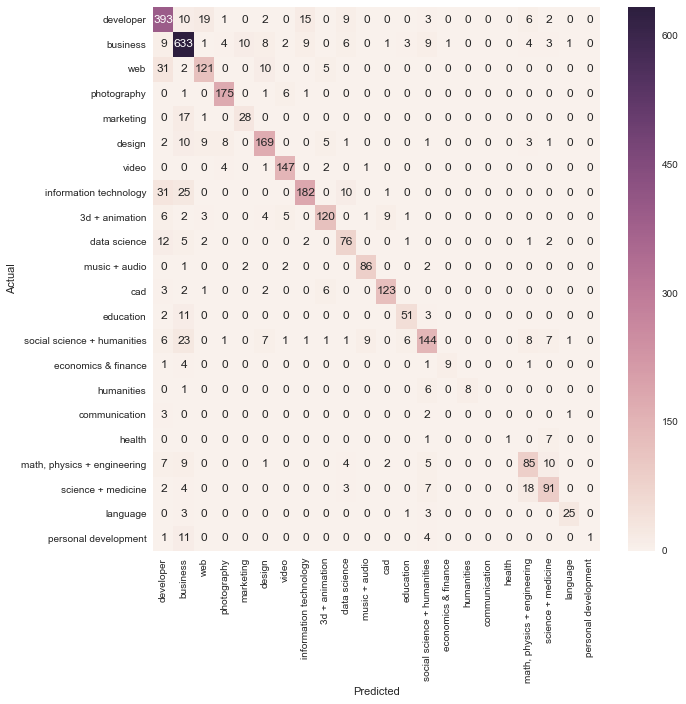

In [12]:
from sklearn.svm import LinearSVC

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.subject.values, yticklabels=category_id_df.subject.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [13]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['subject'].unique()))

                             precision    recall  f1-score   support

                  developer       0.77      0.85      0.81       460
                   business       0.82      0.90      0.86       704
                        web       0.77      0.72      0.74       169
                photography       0.91      0.95      0.93       184
                  marketing       0.70      0.61      0.65        46
                     design       0.82      0.81      0.82       209
                      video       0.90      0.95      0.92       155
     information technology       0.87      0.73      0.79       249
             3d + animation       0.86      0.79      0.83       151
               data science       0.69      0.75      0.72       101
              music + audio       0.89      0.92      0.91        93
                        cad       0.90      0.90      0.90       137
                  education       0.81      0.76      0.78        67
social science + humanities      

//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
